# Seminar 5: Tree and Bootstrap Aggregation
Course: MA06018, Machine Learning by professor Evgeny Burnaev <br\>
Author: Evgenii Egorov

### Table of contents:
* [Tree](#tree)
    * [Simple Stamp](#stamp)
    * [Limitations of trees](#lim)
* [Bagging](#bag)
    * [Bootstrap](#bootbag)
    * [Random Forest](#rf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<a id='tree'></a>
# Tree

Let's play with a toy example and write our own decion-regression stamp. First, consider following toy dataset: 

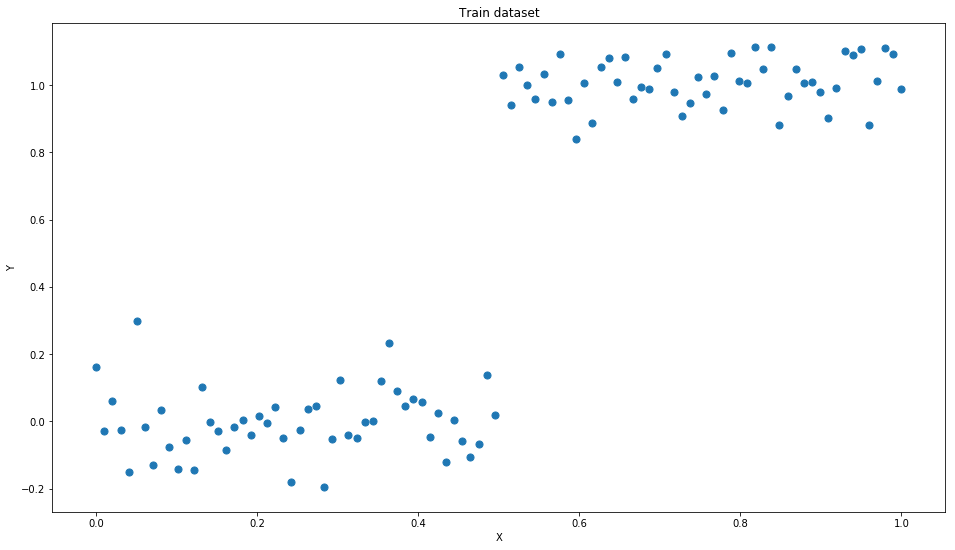

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1
Y_test = target(X_test) + np.random.randn(*X_test.shape) * 0.1

plt.figure(figsize = (16, 9));
plt.scatter(X_train, Y_train, s=50);
plt.title('Train dataset');
plt.xlabel('X');
plt.ylabel('Y');

<a id='stamp'></a>
### Task 1

To define tree (even that simple), we need to define following functions:

*** Loss function *** 
For regression it can be MSE, MAE .etc We will use MSE

$$
\begin{aligned}
& y \in \mathbb{R}^N \\
& \text{MSE}(\hat{y}, y) = \dfrac{1}{N}\|\hat{y} -  y\|_2^2
\end{aligned}
$$

Note, that for MSE optimal prediction will be just mean value of the target.

*** Gain function *** 
We need to select over different splitting by comparing them with their gain value. It is also reasonable to take into account number of points at the area of belongs to the split.

$$
\begin{aligned}
& R_i := \text{region i; c = current, l = left, r = right} \\
& Gain(R_c, R_l, R_r) = Loss(R_c) - \left(\frac{|R_l|}{|R_c|}Loss(R_l) + \frac{|R_r|}{|R_c|}Loss(R_r)\right)
\end{aligned}
$$


Also for efficiency, we should not try all the x values, but just according to the histogram

<img src="stamp.jpg" alt="Stamp Algo" style="height: 700px;"/>

Also don't forget return left and right leaf predictions

Implement algorithm and please, put your loss rounded to the 3 decimals at the form: https://goo.gl/forms/AshZ8gyirm0Zftz53


In [3]:
def loss_mse(predict, true):
    return np.mean((predict - true) ** 2)

def stamp_fit(x, y):
    root_prediction = np.mean(y)
    root_loss = loss_mse(root_prediction, y)
    gain = []
    _, thresholds = np.histogram(x)
    thresholds = thresholds[1:-1]
    for i in thresholds:
        left_predict = np.mean(y[x < i])
        left_weight = np.sum(x < i) / x.shape[0]
        
        right_predict = np.mean(y[x >= i])
        right_weight = np.sum(x >= i) / x.shape[0]
        
        loss = left_weight * loss_mse(left_predict, y[x < i]) +  right_weight * loss_mse(right_predict, y[x >= i])
        gain.append(root_loss - loss)
    
    threshold = thresholds[np.argmax(gain)]
    left_predict = np.mean(y[x < threshold])
    right_predict = np.mean(y[x >= threshold])
    
    return threshold, left_predict, right_predict

@np.vectorize
def stamp_predict(x, threshold, predict_l, predict_r):
    prediction = predict_l if x < threshold else predict_r
    return prediction

In [4]:
predict_params = stamp_fit(X_train, Y_train)

In [5]:
prediction = stamp_predict(X_test, *predict_params)

In [6]:
loss_mse(prediction, Y_test)

0.010699235982691863

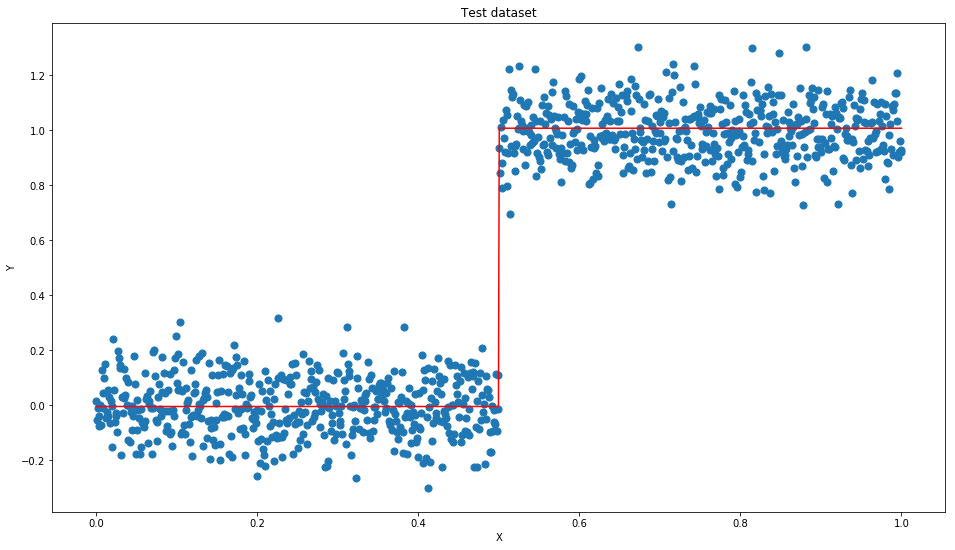

In [7]:
plt.figure(figsize = (16, 9));
plt.scatter(X_test, Y_test, s=50);
plt.plot(X_test, prediction, 'r');
plt.title('Test dataset');
plt.xlabel('X');
plt.ylabel('Y');

<a id='lim'></a>
## Limitations 

Now let's discuss some limitations of decision trees. Consider another toy example. Our target is distance between the origin $(0;0)$ and data point $(x_1, x_2)$

In [10]:
from sklearn.tree import DecisionTreeRegressor

In [8]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

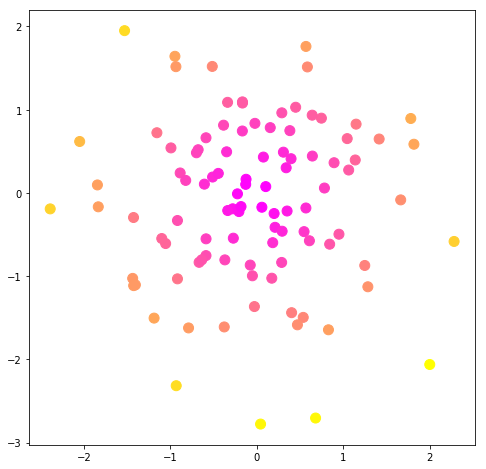

In [9]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5
plt.figure(figsize=(8, 8));
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring');

### Sensitivity with respect to the subsample

Let's see how predictions and structure of tree change, if we fit them at the random $90\%$ subset if the data.

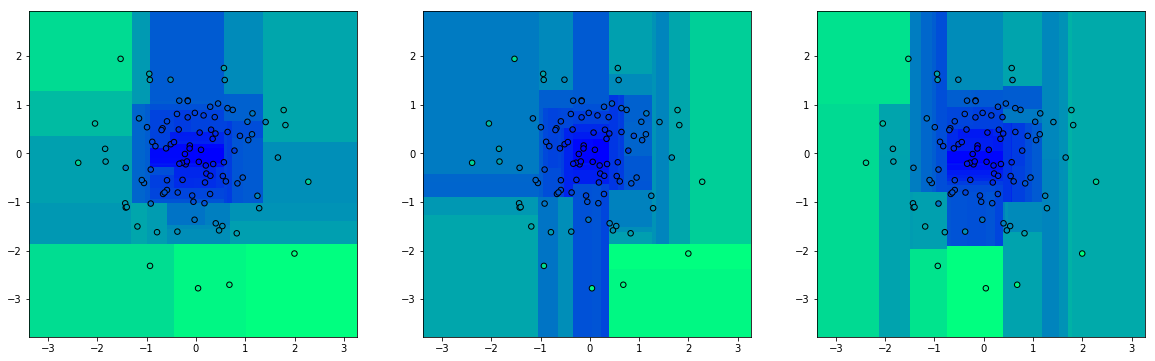

In [11]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')


### Sensitivity with respect to  the hyper parameters

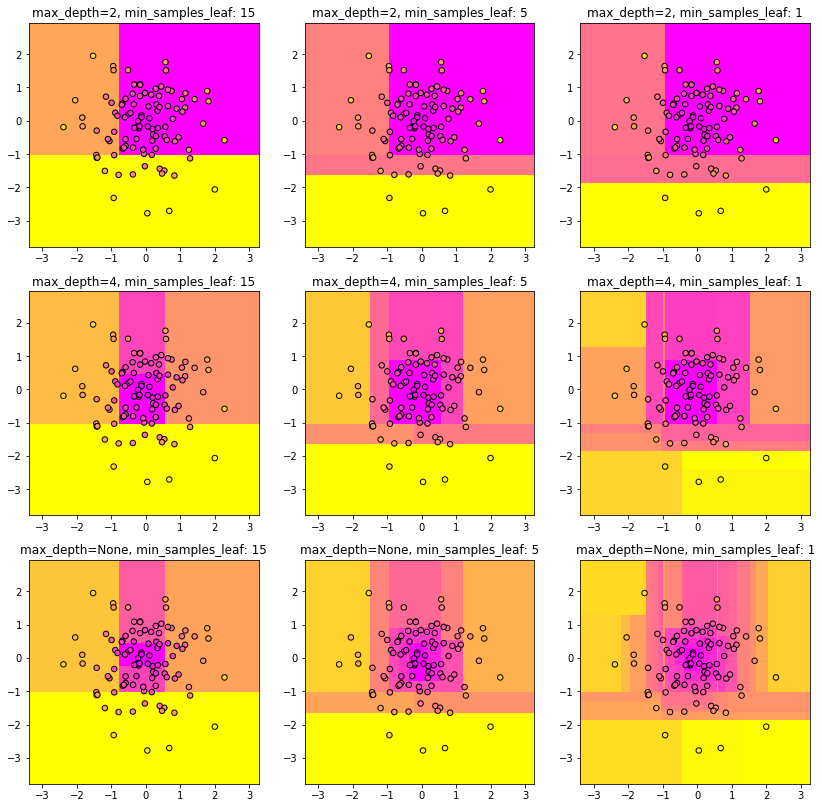

In [12]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

To overcome this disadvantages, we will consider *** bagging or bootstrap aggregation ***

<a id='bootbag'></a>
# Bagging

<a id='bootbag'></a>
## Bootstrap

Usually, we apply the following approach to the ML problem:

1. We have some finite sample $X=\{x_i\}_{i=1}^{N}$, $x_i\in\mathbb{R}^{d}$ from unknown complex distirubution $F$
2. Inference some machine learning algorithm $T = T(x_1,\dots,x_N)$

However, if we want to study statistical proporities of the algorithm, we are in the trouble. For variance:

$$
\mathbb{V}T = \int_{\text{range } x}(T(x))^2dF(x) - \left(\int_{\text{range } x}T(x)dF(x)\right)^2
$$

** Troubles: **
 * We do not have the true distribution $F(x)$ 
 * We can not analytically integrate over complex ml-algorithm $T$ as tree, or even median
 
** Solutions: **
 * Model $F(y)$ with emperical density $p_e(y)$:
 
 $$ p_{e}(y) = \sum\limits_{i=1}^{N}\frac{1}{N}\delta(y-x_i) $$
 
 * Esitemate any integral of the form $\int f(T(x))dF(x)\approx \int f(T(x))dF_{e}(x)$ via Mone-Carlo:
 
 $$
 \int f(T(x))dF(x)\approx \int f(T(x))dF_{e}(x) \approx \frac{1}{B}\sum\limits_{j=1}^{B}f(T_j),\text{where } T_j = T(X^j), X^j\sim F_e
 $$
 
 
Note, that ** sampling ** from $p_e(y)$ is just selection with repetition from $X=\{x_i\}_{i=1}^{N}$. So it is the cheap and simple procedure. 

Let's play with model example and estimate variance of the algorithm:


$$
\begin{aligned}
& x_i \in \mathbb{R} \\
& T(X) = \text{median }X
\end{aligned}
$$

![Scheme of bootstrap aggregation](bootstrap.jpg)

### Task 1

For this example let's make simultated data from Cauchy distribution

In [13]:
def median(X):
    return np.median(X)

def make_sample_cauchy(n_samples):
    sample = np.random.standard_cauchy(size=n_samples)
    return sample

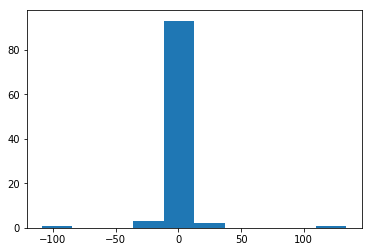

In [14]:
X = make_sample_cauchy(int(1e2))
plt.hist(X, bins=int(1e1));

So, our model ** median ** will be:

In [15]:
med = median(X)
med

0.079852983102022893

Exact variance formula for sample cauchy median is following:

$$
\mathbb{V}\text{med($X_n$)} = \dfrac{2n!}{(k!)^2\pi^n}\int\limits_{0}^{\pi/2}x^k(\pi-x)^k(\text{cot}x)^2dx
$$

So hard! We will find it by bootstrap method.

Now, please apply boostrap algorithm to calculate its variance. 

First, you need to write bootstrap sampler. It will be usefull https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.choice.html#numpy.random.choice

In [16]:
def make_sample_bootstrap(X):
    size = X.shape[0]
    idx_range = range(size)
    new_idx = np.random.choice(idx_range, size, replace=True)
    return X[new_idx]

Second, for $K$ bootstrap samples your shoud estimate its median.

1. Make K=500 samples
2. For each samples estimate median ont it
3. save in median_boot_samples array

In [17]:
K = 500
median_boot_samples = []
for i in range(K):
    boot_sample = make_sample_bootstrap(X)
    meadian_boot_sample = median(boot_sample)
    median_boot_samples.append(meadian_boot_sample)
median_boot_samples = np.array(median_boot_samples)

Now we can obtain mean and variance from *** median_boot_samples *** as we are usually done it in statistics

In [18]:
mean = np.mean(median_boot_samples)
std = np.std(median_boot_samples)
print(mean, std)

0.0927211126765 0.173272821996


Please, put your estimation of std rounded to the 3 decimals at the form:
https://goo.gl/forms/Qgs4O7U1Yvs5csnM2

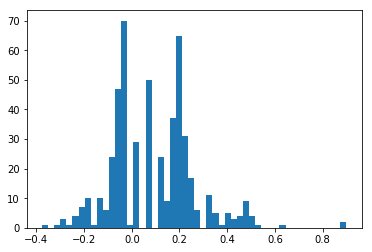

In [19]:
plt.hist(median_boot_samples, bins=int(50));

<a id='rf'></a>
# Tree + Bootstrap = Random Forest

We want to make many different trees and then aggregate score. So, we need to specify what is different and how to aggregate.

*** How to aggregate ***

For base algorithms $b_1(x),\dots, b_N(x)$

* For classification task => majority vote: $a(x) = \text{arg}\max_{y}\sum_{i=1}^N[b_i(x) = y]$ 
* For regression task => $a(x) = \frac{1}{N}\sum_{i=1}^{N}b_i(x)$

*** Different trees *** 

* Note, that more different trees, than less covariance their predictions have. Hence then we get more gain from aggregation.
* One source of the difference: bootstrap sample, as we consider above
* Another one: select random subset of features for each $b_i(x)$ fitting

Let' see how it works on our toy task

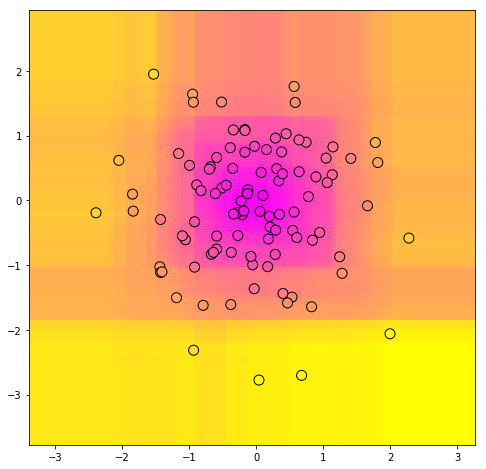

In [20]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8));
plt.pcolormesh(xx, yy, predicted, cmap='spring');
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k');

You can note, that all boundaries become much more smoother. Now we will compare methods on the Boston Dataset

In [21]:
from sklearn.datasets import load_boston

In [22]:
data = load_boston()
X = data.data
y = data.target

### Task 1

Get cross validation score for variety of algorithms: BaggingRegressor and RandomForestRegressor with different parameters.

For example, for simple decision tree:

In [23]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(shuffle=True, random_state=1011)
regr = DecisionTreeRegressor()
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.733146956973


Find best parameter with CV. Please put score at the  https://goo.gl/forms/XZ7xHR54Fjk5cBy92

In [24]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

In [25]:
# usuall cv code